In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/AI_finalproject

/content/drive/MyDrive/AI_finalproject


In [ ]:
ls

archive.zip              garbage_classification_12.ipynb  sample/
garbage_classification/  garbage_model.pkl


In [ ]:
# !unzip "archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/pa

# **Garbage Classification using PyTorch**

In [ ]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import random_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

print('setup successful!')

setup successful!


In [ ]:
# dataset
data_dir  = 'garbage_classification'

classes = os.listdir(data_dir)
print(classes)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


**Transformations**

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

**to count**

In [ ]:
# Get the class names
class_names = dataset.classes

# Initialize a dictionary to store the count of images in each class
class_count = {class_name: 0 for class_name in class_names}

# Iterate through the dataset and count the images in each class
for _, label in dataset:
    class_count[class_names[label]] += 1

# Display class names and the number of images in each class
for class_name, count in class_count.items():
    print(f"Class Name: {class_name}, Number of Images: {count}")

Class Name: battery, Number of Images: 945
Class Name: biological, Number of Images: 985
Class Name: brown-glass, Number of Images: 607
Class Name: cardboard, Number of Images: 891
Class Name: clothes, Number of Images: 5325
Class Name: green-glass, Number of Images: 629
Class Name: metal, Number of Images: 769
Class Name: paper, Number of Images: 1050
Class Name: plastic, Number of Images: 865
Class Name: shoes, Number of Images: 1977
Class Name: trash, Number of Images: 697
Class Name: white-glass, Number of Images: 775


In [ ]:
# Calculate the total number of images in the dataset
total_images = sum(class_count.values())

print(f"Total Number of Images in the Dataset: {total_images}")

Total Number of Images in the Dataset: 15515


**to show**

In [ ]:
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: white-glass (Class No: 11)


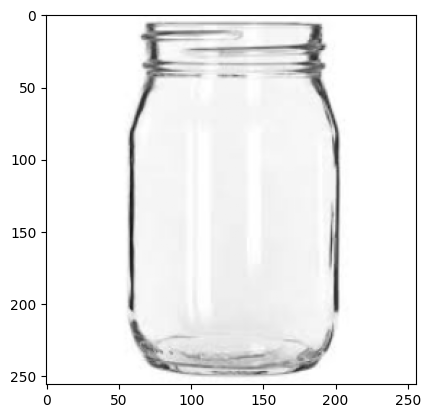

In [ ]:
img, label = dataset[15000]
show_sample(img, label)

# Loading and Splitting Data

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
# Define the sizes for the splits
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to split the dataset
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Get the lengths of each split
len(train_ds), len(val_ds), len(test_ds)

(12412, 1551, 1552)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

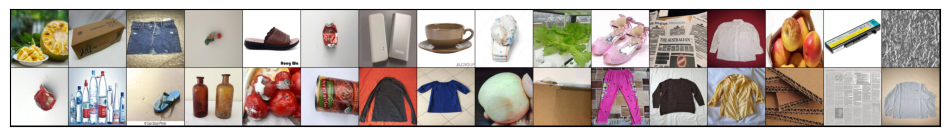

In [ ]:
show_batch(train_dl)

# Model Base

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)

        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s]


**Porting to GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet(), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.7631, val_loss: 1.6523, val_acc: 0.9656
Epoch 2: train_loss: 1.6540, val_loss: 1.6493, val_acc: 0.9700
Epoch 3: train_loss: 1.6389, val_loss: 1.6426, val_acc: 0.9737
Epoch 4: train_loss: 1.6329, val_loss: 1.6420, val_acc: 0.9775
Epoch 5: train_loss: 1.6287, val_loss: 1.6446, val_acc: 0.9719
Epoch 6: train_loss: 1.6283, val_loss: 1.6452, val_acc: 0.9706
Epoch 7: train_loss: 1.6263, val_loss: 1.6399, val_acc: 0.9762
Epoch 8: train_loss: 1.6260, val_loss: 1.6429, val_acc: 0.9725
Epoch 9: train_loss: 1.6271, val_loss: 1.6419, val_acc: 0.9719
Epoch 10: train_loss: 1.6245, val_loss: 1.6479, val_acc: 0.9644


In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'val_loss': 1.6479339599609375, 'val_acc': 0.9643750190734863}

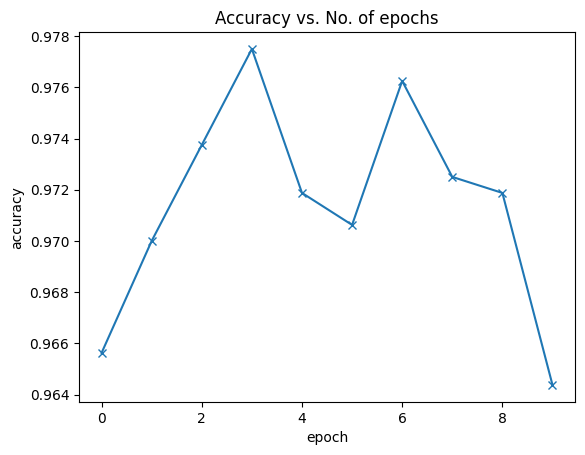

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

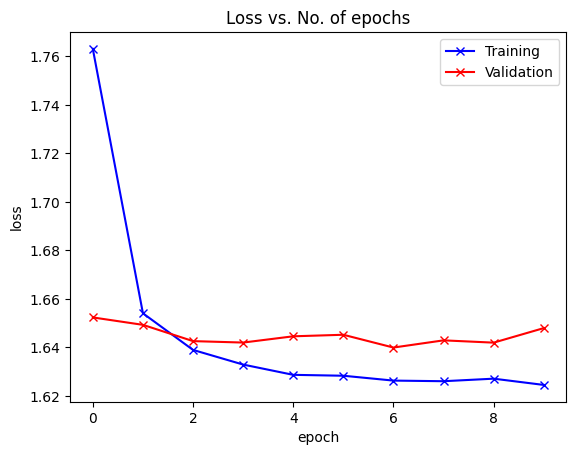

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

**Confusion Matrix**

Confusion Matrix:
[[ 89   0   1   0   0   1   4   1   0   0   0   0]
 [  0  91   1   0   0   0   0   0   0   0   0   0]
 [  0   1  65   0   0   0   0   0   0   0   0   0]
 [  0   0   2  64   1   0   0   4   0   0   0   0]
 [  0   0   0   0 546   0   0   1   2   3   0   0]
 [  0   0   0   0   0  58   1   0   1   0   0   0]
 [  0   0   0   0   0   0  74   0   1   0   0   1]
 [  1   0   0   0   1   0   1 115   1   0   0   0]
 [  0   0   0   0   0   0   1   1  68   0   0   5]
 [  1   1   0   0   1   0   0   1   0 201   0   0]
 [  1   1   0   0   0   0   0   0   7   0  59   0]
 [  0   0   0   0   0   0   1   0   6   0   0  64]]


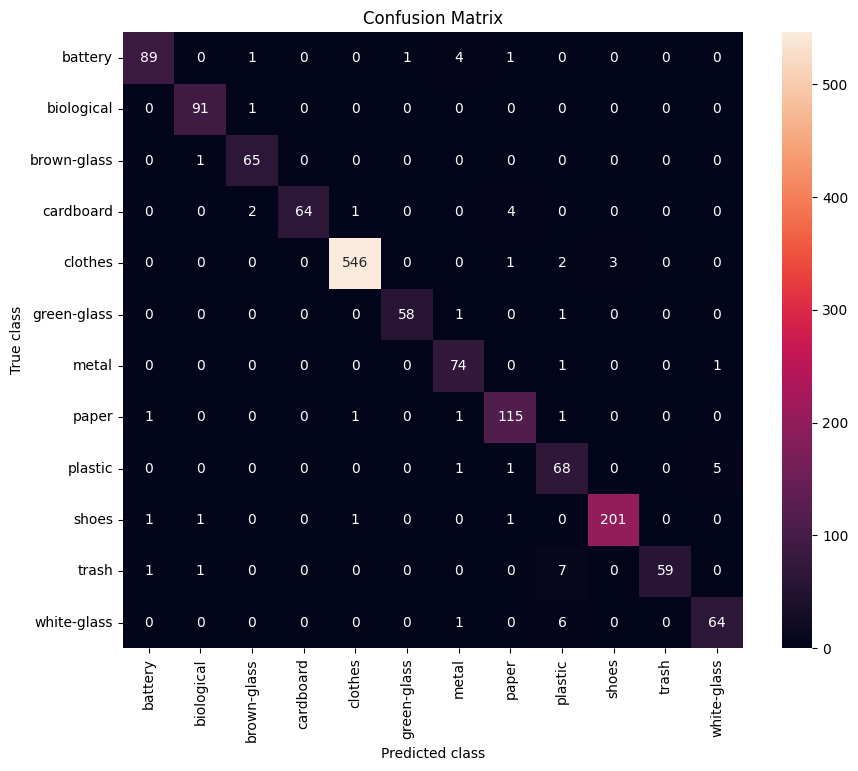

In [ ]:
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions for the validation dataset
val_preds, val_labels = get_predictions(model, val_dl)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(val_labels, val_preds)

# Print and visualize the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

# plot the confusion matrix
LABELS = dataset.classes
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

**Classification Report**

In [ ]:
# Generate a classification report
class_report = classification_report(val_labels, val_preds, target_names=dataset.classes)

# Print the classification report
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     battery       0.97      0.93      0.95        96
  biological       0.97      0.99      0.98        92
 brown-glass       0.94      0.98      0.96        66
   cardboard       1.00      0.90      0.95        71
     clothes       0.99      0.99      0.99       552
 green-glass       0.98      0.97      0.97        60
       metal       0.90      0.97      0.94        76
       paper       0.93      0.97      0.95       119
     plastic       0.79      0.91      0.84        75
       shoes       0.99      0.98      0.98       205
       trash       1.00      0.87      0.93        68
 white-glass       0.91      0.90      0.91        71

    accuracy                           0.96      1551
   macro avg       0.95      0.95      0.95      1551
weighted avg       0.97      0.96      0.96      1551



Saving the model

In [ ]:
torch.save(model, '/content/drive/MyDrive/AI_finalproject/garbage_model.pt')

# Visualizing Predictions

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: shoes , Predicted: shoes


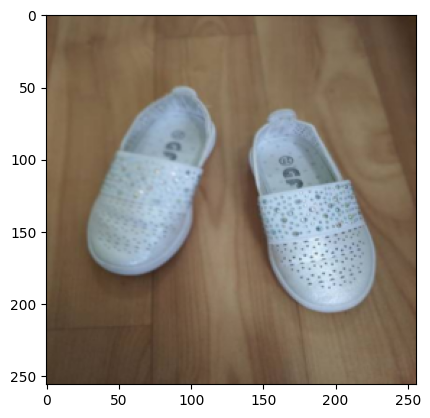

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


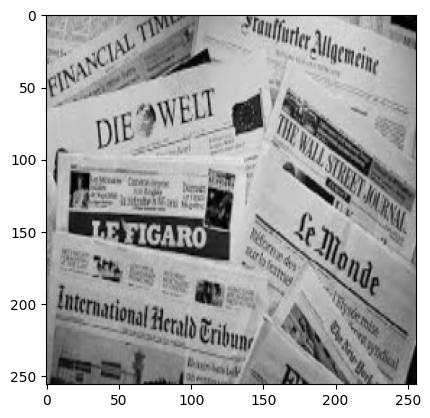

In [ ]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: clothes , Predicted: clothes


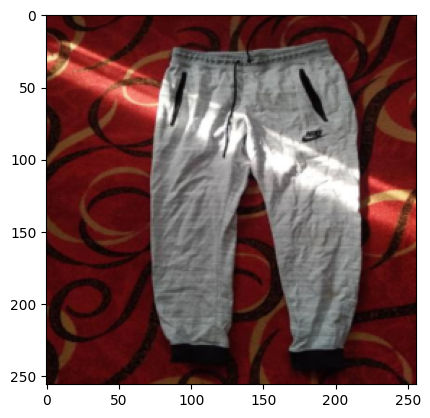

In [ ]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting New Images

In [ ]:
def predict_image_drive(image_path, model, dataset):
    # Define the image transformation
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),  # Convert the image to a tensor
    ])

    # Load and preprocess the image from Google Drive
    image = Image.open(image_path)
    processed_image = transform(image).unsqueeze(0)  # Add a batch dimension
    processed_image = processed_image.to(device)  # Move the image to the device (GPU if available)

    # Get predictions from the model
    with torch.no_grad():
        output = model(processed_image)
        _, predicted_class = torch.max(output, dim=1)

    # Retrieve the class label
    predicted_label = dataset.classes[predicted_class[0].item()]

    # Move the processed_image to CPU before displaying
    processed_image_cpu = processed_image.cpu()

    # Display the image and predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_image_cpu.squeeze().permute(1, 2, 0))  # Remove the batch dimension and permute the dimensions
    plt.title(f'Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()
    return predicted_label


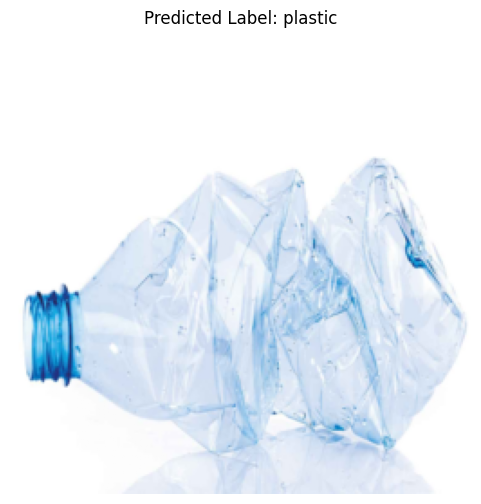

Predicted Label: plastic


In [ ]:
# Define the path to the image in Google Drive
image_path = '/content/drive/MyDrive/AI_finalproject/sample/plastic.jpg'

# Predict the image
predicted_label = predict_image_drive(image_path, model, dataset)

# Print the predicted label
print('Predicted Label:', predicted_label)

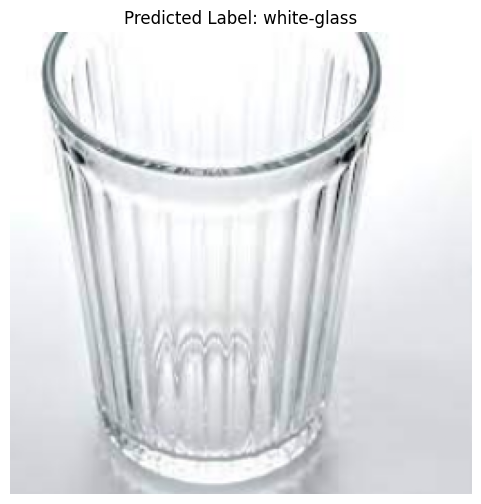

Predicted Label: white-glass


In [ ]:
# Define the path to the image in Google Drive
image_path = '/content/drive/MyDrive/AI_finalproject/sample/white-glass.jpg'

# Predict the image
predicted_label = predict_image_drive(image_path, model, dataset)

# Print the predicted label
print('Predicted Label:', predicted_label)

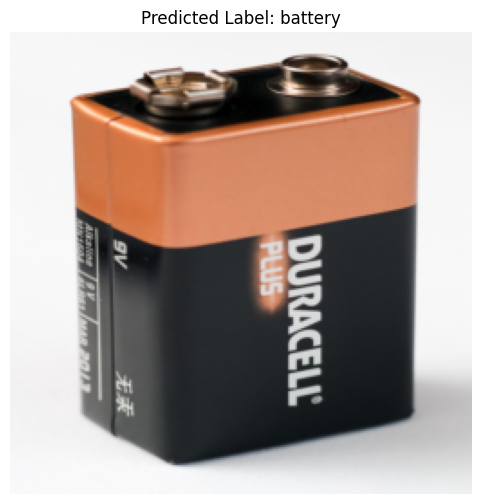

Predicted Label: battery


In [ ]:
# Define the path to the image in Google Drive
image_path = '/content/drive/MyDrive/AI_finalproject/sample/battery.jpg'

# Predict the image
predicted_label = predict_image_drive(image_path, model, dataset)

# Print the predicted label
print('Predicted Label:', predicted_label)

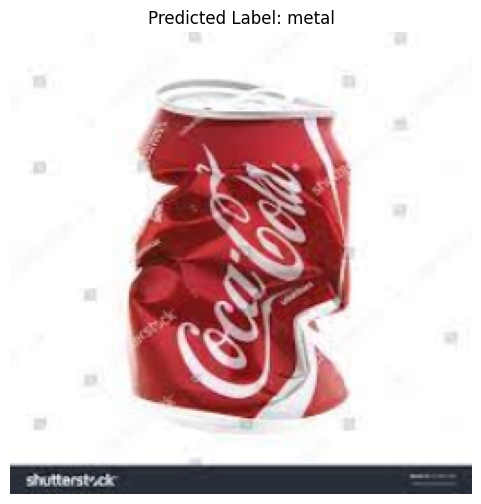

Predicted Label: metal


In [ ]:
# Define the path to the image in Google Drive
image_path = '/content/drive/MyDrive/AI_finalproject/sample/cola.jpg'

# Predict the image
predicted_label = predict_image_drive(image_path, model, dataset)

# Print the predicted label
print('Predicted Label:', predicted_label)

# Predicting with saved model pkl file

In [ ]:
import torch

# Define the path to saved model file
model_path = '/content/drive/MyDrive/AI_finalproject/garbage_model.pt'

# Load the saved model
loaded_model = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Set the model to evaluation mode
loaded_model.eval()

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
def predict_with_saved_model(image_path, loaded_model, dataset):
    # Define the image transformation
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),  # Convert the image to a tensor
    ])

    # Load and preprocess the image from Google Drive
    image = Image.open(image_path)
    processed_image = transform(image).unsqueeze(0)  # Add a batch dimension
    processed_image = processed_image.to(device)  # Move the image to the device (GPU if available)

    # Get predictions from the model
    with torch.no_grad():
        output = model(processed_image)
        _, predicted_class = torch.max(output, dim=1)

    # Retrieve the class label
    predicted_label = dataset.classes[predicted_class[0].item()]

    # Move the processed_image to CPU before displaying
    processed_image_cpu = processed_image.cpu()

    # Display the image and predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_image_cpu.squeeze().permute(1, 2, 0))  # Remove the batch dimension and permute the dimensions
    plt.title(f'Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()
    return predicted_label


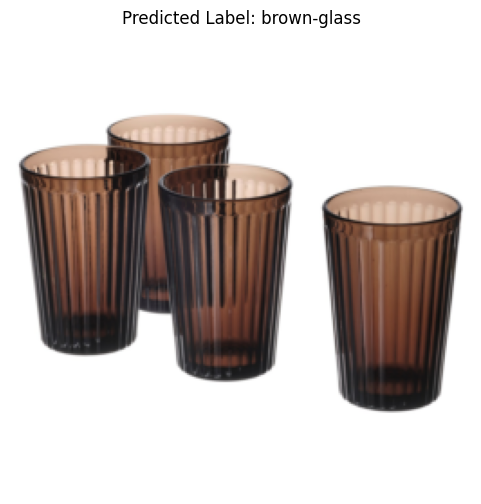

Predicted Label: brown-glass


In [ ]:
# Define the path to the image in Google Drive
image_path = '/content/drive/MyDrive/AI_finalproject/sample/brown-glass.jpg'

# Predict the image
predicted_label = predict_with_saved_model(image_path, loaded_model, dataset)

# Print the predicted label
print('Predicted Label:', predicted_label)

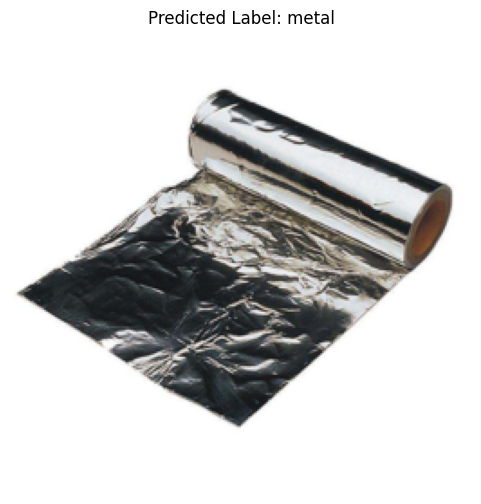

Predicted Label: metal


In [ ]:
# Define the path to the image in Google Drive
image_path = '/content/drive/MyDrive/AI_finalproject/sample/tinfoil.jpeg'

# Predict the image
predicted_label = predict_with_saved_model(image_path, loaded_model, dataset)

# Print the predicted label
print('Predicted Label:', predicted_label)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Confusion Matrix:
[[ 89   0   1   0   0   1   4   1   0   0   0   0]
 [  0  91   1   0   0   0   0   0   0   0   0   0]
 [  0   1  65   0   0   0   0   0   0   0   0   0]
 [  0   0   2  64   1   0   0   4   0   0   0   0]
 [  0   0   0   0 546   0   0   1   2   3   0   0]
 [  0   0   0   0   0  58   1   0   1   0   0   0]
 [  0   0   0   0   0   0  74   0   1   0   0   1]
 [  1   0   0   0   1   0   1 115   1   0   0   0]
 [  0   0   0   0   0   0   1   1  68   0   0   5]
 [  1   1   0   0   1   0   0   1   0 201   0   0]
 [  1   1   0   0   0   0   0   0   7   0  59   0]
 [  0   0   0   0   0   0   1   0   6   0   0  64]]


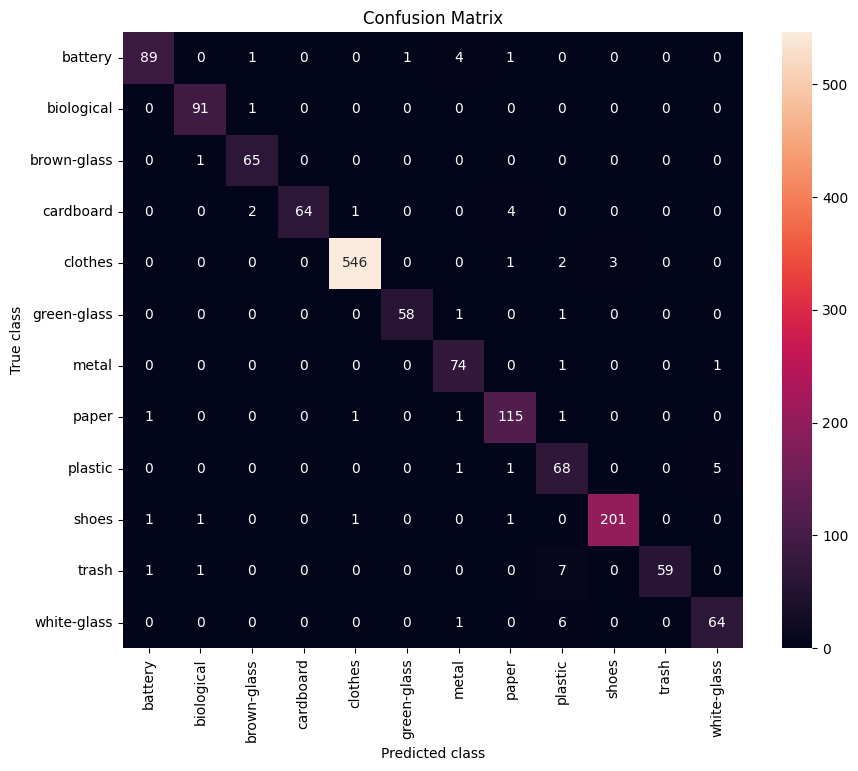

In [ ]:
def get_predictions(loaded_model, data_loader):
    loaded_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = loaded_model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions for the validation dataset
val_preds, val_labels = get_predictions(loaded_model, val_dl)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(val_labels, val_preds)

# Print and visualize the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

# plot the confusion matrix
LABELS = dataset.classes
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()